In [2]:
import pandas as pd
import overpass
import utilities
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import time

In [3]:
df_traffic = pd.read_csv('vt_2017_avg_daily_traffic_190919.csv', index_col=0)
df_traffic['lat_lon_list'] = [utilities.process_coord_string(line_segment) for line_segment in df_traffic.line]
utilities.process_lines(df_traffic)

In [5]:
lengths = [line.length for line in df_traffic.line]

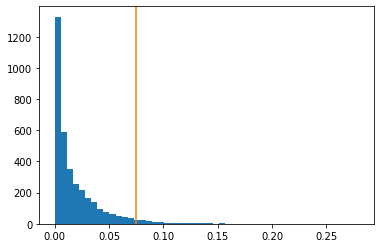

In [6]:
plt.hist(lengths, bins=50)
plt.axvline(0.075, color='C1')
None

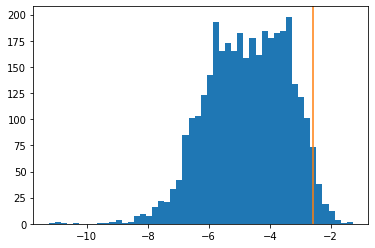

In [7]:
plt.hist(np.log(lengths), bins=50)
plt.axvline(np.log(0.075), color='C1')
None

max_line_units=0.07381197609536122
    is set for 5 mile increments

# Splitting road segments that are too long

In [8]:
cutoff = 0.075
series_list, exclude_list = list(), list()
for index, row in df_traffic.iterrows():
    if row.line.length > cutoff:
        exclude_list.append(index)
        for line in utilities.split_line(row.line, cutoff):
            temp_series = row.copy()
            temp_series.line = line
            temp_series.mid_point = line.interpolate(0.5, normalized = True)
            series_list.append(temp_series)

mask = ~df_traffic.index.isin(exclude_list)
df_traffic_shortened = df_traffic[mask].append(pd.DataFrame(series_list), ignore_index=True, sort=False)

In [16]:
df_traffic_shortened.to_csv('vt_2017_avg_daily_traffic_SHORTENED_191001.csv')

# Overpass data collection
Using code from `feature_production_190925.ipynb`.

In [126]:
folder = 'vt_traffic_overpass_data'

In [127]:
api_pass = overpass.API(timeout=600)

In [128]:
import importlib
importlib.reload(utilities)

<module 'utilities' from '/home/jeremy/insight/deer_xing/vt_model/utilities.py'>

In [130]:
cols = [
    'aeroway',
    'amenity',
    'barrier',
    'boundary',
    'building',
    'healthcare',
    'highway',
    'landuse',
    'leisure',
    'man_made',
    'natural',
    'parking',
    'power',
    'railway',
    'route',
    'service',
    'surface',
    'tourism',
    'waterway'
]

In [134]:
endpoint = 'https://overpass.kumi.systems/api/interpreter'
endpoint = 'https://z.overpass-api.de/api/interpreter'
endpoint = 'https://lz4.overpass-api.de/api/interpreter'
api_pass = overpass.API(timeout=7200, endpoint=endpoint)
#road_responses, area_responses = list(), list()
i = 10

for index, row in df_traffic_shortened.iloc[i:,:].iterrows(): 
    print(i, end=', ')
    poly = row.line.buffer(.0025, cap_style=3)
    test_shape = poly.simplify(0.001, preserve_topology=False)

    # Building overpass queries
    road_query = 'nwr(around:1, {c[0]}, {c[1]});(._;>;);out;'.format(
        c=row.mid_point.coords[:][0])
    area_query = 'nwr(poly:"{}");out;'.format(
        ' '.join('{c[0]} {c[1]}'.format(c=c) for c in test_shape.exterior.coords[:]))

    # Getting overpass road responses
    road_response = api_pass.get(road_query)
    #road_responses.append(road_response)
    road_geodf = geopandas.GeoDataFrame.from_features(road_response)
    culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
    # Overwriting feature_dict each time
    feature_dict = utilities.make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')
    time.sleep(2)

    # Getting overpass area responses
    response = api_pass.get(area_query)
    #area_responses.append(response)
    geodf = geopandas.GeoDataFrame.from_features(response)
    culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
    feature_dict.update(utilities.make_feature_dict(culled_geodf, cols, prefix='area_'))
    pd.io.json.json_normalize(feature_dict).to_csv('{}/{}.csv'.format(folder, str(i).rjust(4,'0')))
    time.sleep(2)
    i += 1

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 

In [132]:
road_geodf

,geometry,crossing,highway,change:backward,change:forward,lanes,lit,name,overtaking,source:name,surface,service
0,POINT (-73.20769900000001 44.4647),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-73.207762 44.464003),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-73.207629 44.463585),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-73.20761299999999 44.46368),unmarked,crossing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-73.207701 44.464745),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,POINT (-73.207638 44.46398),unmarked,crossing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,POINT (-73.207564 44.463966),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,POINT (-73.207564 44.463966),NaN,tertiary,no,no,2,yes,Shelburne Road,no,Vermont State Interactive Map Viewer Beta (htt...,asphalt,NaN
8,POINT (-73.207564 44.463966),NaN,service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,asphalt,parking_aisle
9,POINT (-73.20769900000001 44.4647),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df_traffic_shortened.iloc[0,:].mid

OBJECTID                                                             1
AADT                                                             10300
BeginMM                                                              0
BeginRefName                                                      US 5
BeginStation                                                         0
CTCode                                                            1408
EndMM                                                             0.05
EndRefName                                                  BESWICK DR
EndRefNum                                                       TH 179
EndStation                                                         264
ETE_ID                                                           S0325
ETE_BeginMM                                                          0
ETE_EndMM                                                         0.05
FunctionalClass                                                      5
RouteN